In [1]:
%matplotlib inline
######################################################################################################
#
#         SCRIPT DESCRIPTION: Basic Q-Learning in a single intersection
#
#         Input: Map name, route file
#         Output: Tripinfo.xml
#
#####################################################################################################

# Set OPERATING SYSTEM
OS = "windows"
# Set MAP and time
used_map = 'triple_straight_random'
# Select whether to color code the vehicles
data_tracking = True
positional_tracking = True
# Set Path for Sumo Home folder
if OS == "iOS":
    sumo_home_dir = "/Users/acabrejasegea/sumo-0.32/"
elif OS == "windows":
    sumo_home_dir = "C:\Program Files (x86)\DLR\Sumo"
else:
    sys.exit("Please declare a supported operative system")

# Import basic libraries
import os
import sys
import optparse
import subprocess
import random
import random
import pdb
import xmltodict
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
from __future__ import absolute_import
from __future__ import print_function
import json

# Current working directory
working_dir = os.getcwd()

# Set environment variable SUMO_HOME
try:
    # Use this line only to manually define SUMO_HOME path
    os.environ["SUMO_HOME"] = sumo_home_dir
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
except ImportError:
    sys.exit(
        "Please declare environment variable 'SUMO_HOME' as the root directory of your sumo installation (it should contain folders 'bin', 'tools' and 'docs')")

# Import API libraries
from sumolib import checkBinary
import traci

In [2]:
%%bash
echo $SUMO_HOME

Couldn't find program: 'bash'


In [3]:
%%javascript
IPython.notebook.kernel.execute('notebook_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [4]:
# Set important directories
if OS=="iOS":
    networks_dir = "/Users/acabrejasegea/sumo-0.32/Data/Networks/"
    scripts_dir = "/Users/acabrejasegea/sumo-0.32/tools/"
    runners_dir = "/Users/acabrejasegea/Desktop/ATI_Project/MLforFlowOptimisation/"
elif OS=="windows":
    networks_dir = "C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Networks"
    scripts_dir = "C:\\Program Files (x86)\\DLR\\Sumo\\tools\\"
    runners_dir = "C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Runners"
else:
    sys.exit("Please declare a supported operative system")
notebook = (os.path.splitext(notebook_name))[0]

In [61]:
positional_tracking = True
tracking_length = 3600

positional_data = [[] for _ in range(tracking_length)]

In [62]:
def run(learners = []):
    cycle_timer = 0
    timer = 0
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()
        timer = timer + 1
        if cycle_timer == 90:
            for learner in learners:
                learner.update()
            cycle_timer = 0
        else:
            cycle_timer = cycle_timer + 1    
        if data_tracking == True:
            combined_queue.append(traci.lane.getLastStepHaltingNumber(learners[0].laneids[0])+
                                     traci.lane.getLastStepHaltingNumber(learners[0].laneids[1])+
                                     traci.lane.getLastStepHaltingNumber(learners[0].laneids[2])+
                                     traci.lane.getLastStepHaltingNumber(learners[0].laneids[3])+
                                     traci.lane.getLastStepHaltingNumber(learners[1].laneids[0])+
                                     traci.lane.getLastStepHaltingNumber(learners[1].laneids[1])+
                                     traci.lane.getLastStepHaltingNumber(learners[1].laneids[2])+
                                     traci.lane.getLastStepHaltingNumber(learners[1].laneids[3])+
                                     traci.lane.getLastStepHaltingNumber(learners[2].laneids[0])+
                                     traci.lane.getLastStepHaltingNumber(learners[2].laneids[1])+
                                     traci.lane.getLastStepHaltingNumber(learners[2].laneids[2])+
                                     traci.lane.getLastStepHaltingNumber(learners[2].laneids[3]))
            for j in range(3):
                for k in range(4):
                    learners[j].historic_queues[k].append(traci.lane.getLastStepHaltingNumber(learners[j].laneids[k]))
            
            if positional_tracking == True:
                vehicles = traci.vehicle.getIDList()
                for vehicle in vehicles:
                    positional_data[timer].append(tuple((vehicle, traci.vehicle.getPosition(vehicle))))
        
        if color_vehicles == True:
            vehicleIDs = traci.vehicle.getIDList()
            waiting_time = list()
            for vehicle in vehicleIDs:
                wait = traci.vehicle.getWaitingTime(vehicle)
                if wait >= 20:
                    traci.vehicle.setColor(vehicle,(255,0,0,255))
                elif wait >= 1:
                    traci.vehicle.setColor(vehicle,(255,255,0,255))
                if persistent_color == False:
                    if wait < 1:
                        traci.vehicle.setColor(vehicle,(0,255,0,255))

    
    sys.stdout.flush()

### ORIGINAL SIMPLE CONTROLLER BELOW ###
# The program looks like this
#    <tlLogic id="0" type="static" programID="0" offset="0">
# the locations of the tls are      NESW
#        <phase duration="31" state="GrGr"/>
#        <phase duration="6"  state="yryr"/>
#        <phase duration="31" state="rGrG"/>
#        <phase duration="6"  state="ryry"/>
#    </tlLogic>
#
#def run():
#    """execute the TraCI control loop"""
#    step = 0
#    # we start with phase 2 where EW has green
#    traci.trafficlight.setPhase("0", 2)
#    while traci.simulation.getMinExpectedNumber() > 0:
#        traci.simulationStep()
#        if traci.trafficlight.getPhase("0") == 2:
#            # we are not already switching
#            if traci.inductionloop.getLastStepVehicleNumber("0") > 0:
#                # there is a vehicle from the north, switch
#                traci.trafficlight.setPhase("0", 3)
#            else:
#                # otherwise try to keep green for EW
#                traci.trafficlight.setPhase("0", 2)
#        step += 1
#    traci.close()
#    sys.stdout.flush()

In [63]:
def get_options():
    optParser = optparse.OptionParser()
    optParser.add_option("--nogui", action="store_true",
                         default=False, help="run the commandline version of sumo")
    options, args = optParser.parse_args()
    return options

In [64]:
# Deployment of Network Parser (input is network file)
npa = NetworkParser(os.path.join(networks_dir, used_map, (used_map + '.net.xml')))

In [65]:
nodes = npa.junctions
phase_list = [len(npa.get_phases(k)) for k in npa.get_junction_trafficlights().keys()]
node_list = list(nodes.keys())

In [66]:
# Checks
print(nodes)
print(nodes.keys())
print(phase_list)

{'Centre1': ['iN1_0', 'oCW_0', 'iS1_0', 'iW_0'], 'Centre2': ['iN2_0', 'iCE_0', 'iS2_0', 'iCW_0'], 'Centre3': ['iN3_0', 'iE_0', 'iS3_0', 'oCE_0']}
dict_keys(['Centre1', 'Centre2', 'Centre3'])
[44, 44, 44]


In [39]:
generate_routefile(simulation_length)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\0_TMF\\MLforFlowOptimisation\\Networks\\triple_straight_random\\triple_straight_random.rou.xml'

In [67]:
sumoBinary = checkBinary('sumo-gui')
# OR
#sumoBinary = checkBinary('sumo')

In [68]:
learners=[Qlearner(ID,lan,p) for ID, lan, p in zip(nodes.keys(),nodes.values(),phase_list)]

In [69]:
combined_queue = []

In [70]:
if reloadQm == True:
    for i in range(len(nodes.keys())):
        if OS == "iOS":
            learners[i].Qm = np.load(networks_dir+used_map+"/"+"Qm_" + str(i)+ demand  + ".npy")
            print("Loaded pre-trained Q-matrix from file: "+networks_dir+used_map+"/"+"Qm_" + str(i)+ demand  + ".npy")
            with open(networks_dir+used_map+"/"+"Reward_" + str(i) + demand  + ".pickle", 'rb') as fp:
                learners[i].historic_reward = pickle.load(fp)
            print("Loaded Reward history to file: "+networks_dir+used_map+"/"+"Reward_" + str(i) + demand  + ".pickle")
        elif OS == "windows":
            learners[i].Qm = np.load(networks_dir+"\\"+used_map+"\\"+"Qm_" + str(i)+ demand  + ".npy")
            print("Loaded pre-trained Q-matrix from file: "+networks_dir+used_map+"\\"+"Qm_" + str(i)+ demand  + ".npy")
            #with open(networks_dir+"\\"+used_map+"\\"+"Reward_" + str(i) + demand  + ".pickle", 'rb') as fp:
            #    learners[i].historic_reward = pickle.load(fp)
            #print("Loaded Reward history to file: "+networks_dir+"\\"+used_map+"\\"+"Reward_" + str(i) + demand  + ".pickle")

Loaded pre-trained Q-matrix from file: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networkstriple_straight_random\Qm_0random.npy
Loaded pre-trained Q-matrix from file: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networkstriple_straight_random\Qm_1random.npy
Loaded pre-trained Q-matrix from file: C:\Users\acabrejasegea\OneDrive - The Alan Turing Institute\Desktop\ATI\0_TMF\MLforFlowOptimisation\Networkstriple_straight_random\Qm_2random.npy


In [71]:
traci.start([sumoBinary, "-c", os.path.join(networks_dir, used_map, (used_map + '.sumocfg')),
                             "--tripinfo-output", os.path.join((notebook + '_out'), 'tripinfo.xml')])

(17, 'SUMO 0.32.0')

In [72]:
run(learners)

C:\Program Files (x86)\DLR\Sumo\tools\traci\domain.py:112: UserWarning: The domain trafficlights is deprecated, use trafficlight instead.
  self._name, self._deprecatedFor))  # , DeprecationWarning)


IndexError: list index out of range

In [ ]:
if saveQm == True:
    for i in range(len(nodes.keys())):
        if OS == "iOS":
            np.save(networks_dir+used_map+"/"+"Qm_" + str(i) + demand + ".npy", learners[i].Qm)
            print("Saved Q-matrix to file: "+networks_dir+used_map+"/"+"Qm_" + str(i) + demand + ".npy")
            with open(networks_dir+used_map+"/"+"Reward_" + str(i) + demand + ".pickle", 'wb') as fp:
                pickle.dump(learners[i].historic_reward, fp)
            print("Saved Reward history to file: "+networks_dir+used_map+"/"+"Reward_" + str(i) + demand + ".pickle")
        elif OS == "windows":
            np.save(networks_dir+"\\"+used_map+"\\"+"Qm_" + str(i) + demand + ".npy", learners[i].Qm)
            print("Saved Q-matrix to file: "+networks_dir+"\\"+used_map+"\\"+"Qm_" + str(i) + demand + ".npy")
            with open(networks_dir+"\\"+used_map+"\\"+"Reward_" + str(i) + demand + ".pickle", 'wb') as fp:
                pickle.dump(learners[i].historic_reward, fp)
            print("Saved Reward history to file: "+networks_dir+"\\"+used_map+"\\"+"Reward_" + str(i) + demand + ".pickle")

In [ ]:
learners[1].Qm

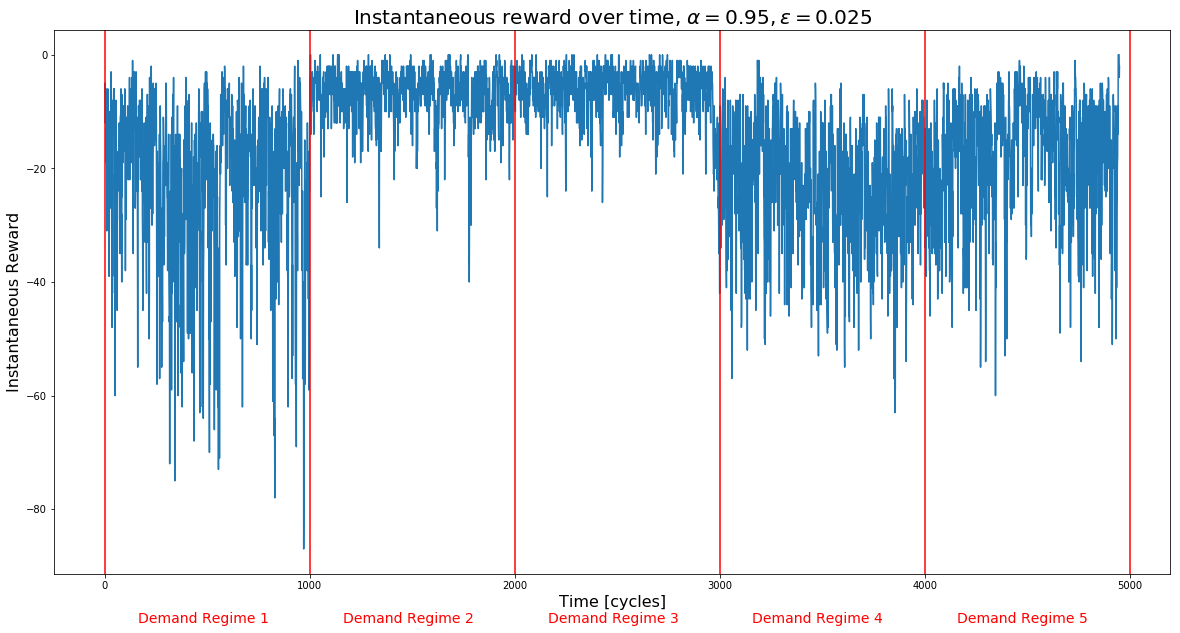

In [102]:
# PLOT GLOBAL TRAINING
plt.figure(figsize=(20,10))
plot_series = [x+y+z for x,y,z in zip(learners[0].historic_reward,learners[1].historic_reward,learners[2].historic_reward)]
plt.plot(plot_series[0:5000])

xcoords = [0,1000,2000,3000,4000,5000]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
    
texts = ['Demand Regime 1', 'Demand Regime 2', 'Demand Regime 3', 'Demand Regime 4', 'Demand Regime 5' ]
for i in range(len(texts)):
    plt.text(xcoords[i]+160,-100,texts[i], fontsize = 14, color='red')

plt.title("Instantaneous reward over time, "+r'$\alpha = 0.95, $' + r'$\epsilon=0.025$', fontsize = 20)
plt.xlabel("Time [cycles]"       , fontsize=16)
plt.ylabel("Instantaneous Reward", fontsize=16)

savedir = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\07_End_of_Internship_Presentation\\'
filename = 'trained_global_'+used_map+'_untrained.png'
plt.savefig(savedir+filename)

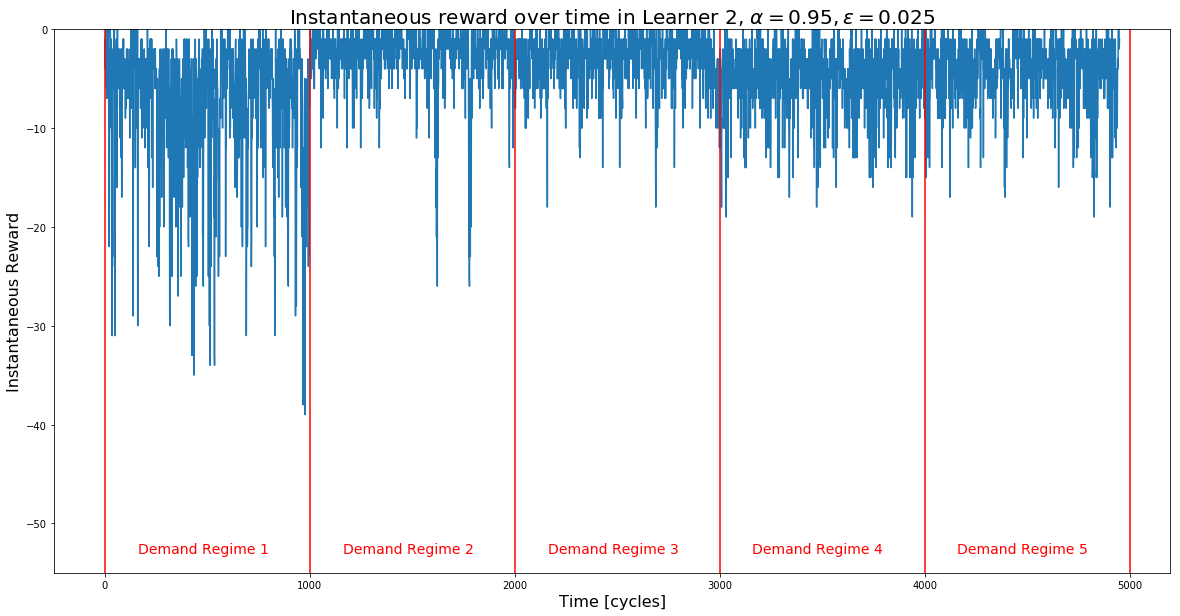

In [105]:
# PLOT TRAINING PER LEARNER
chosen_learner = 2
plt.figure(figsize=(20,10))
plot_series = learners[chosen_learner].historic_reward
plt.plot(plot_series[0:5000])

xcoords = [0,1000,2000,3000,4000,5000]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
    
texts = ['Demand Regime 1', 'Demand Regime 2', 'Demand Regime 3', 'Demand Regime 4', 'Demand Regime 5' ]
for i in range(len(texts)):
    plt.text(xcoords[i]+160,-53,texts[i], fontsize = 14, color='red')

plt.title("Instantaneous reward over time in Learner "+str(chosen_learner)+", "+r'$\alpha = 0.95, $' + r'$\epsilon=0.025$', fontsize = 20)
plt.xlabel("Time [cycles]"       , fontsize=16)
plt.ylabel("Instantaneous Reward", fontsize=16)
plt.ylim(-55,0)

savedir = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\07_End_of_Internship_Presentation\\'
filename = 'trained_partial_'+used_map+'_untrained_learner_'+str(chosen_learner)+'.png'
plt.savefig(savedir+filename)

In [ ]:
trained_cycle = combined_queue[0:90000]
#untrained_cycle = combined_queue

In [ ]:
trained_cycle = trained_cycle[0:90000]
untrained_cycle = untrained_cycle[0:90000]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(trained_cycle[0:15000], color = 'blue', label = "Trained Controller")

 
plt.plot(untrained_cycle[0:15000], color = 'red', label = "Untrained Controller")
plt.legend(prop={'size' : 16})

plt.title("Total stopped vehicles in the model", fontsize = 20)
plt.xlabel("Time [seconds]"       , fontsize=16)
plt.ylabel("Aggregated queue length [vehicles]", fontsize=16)

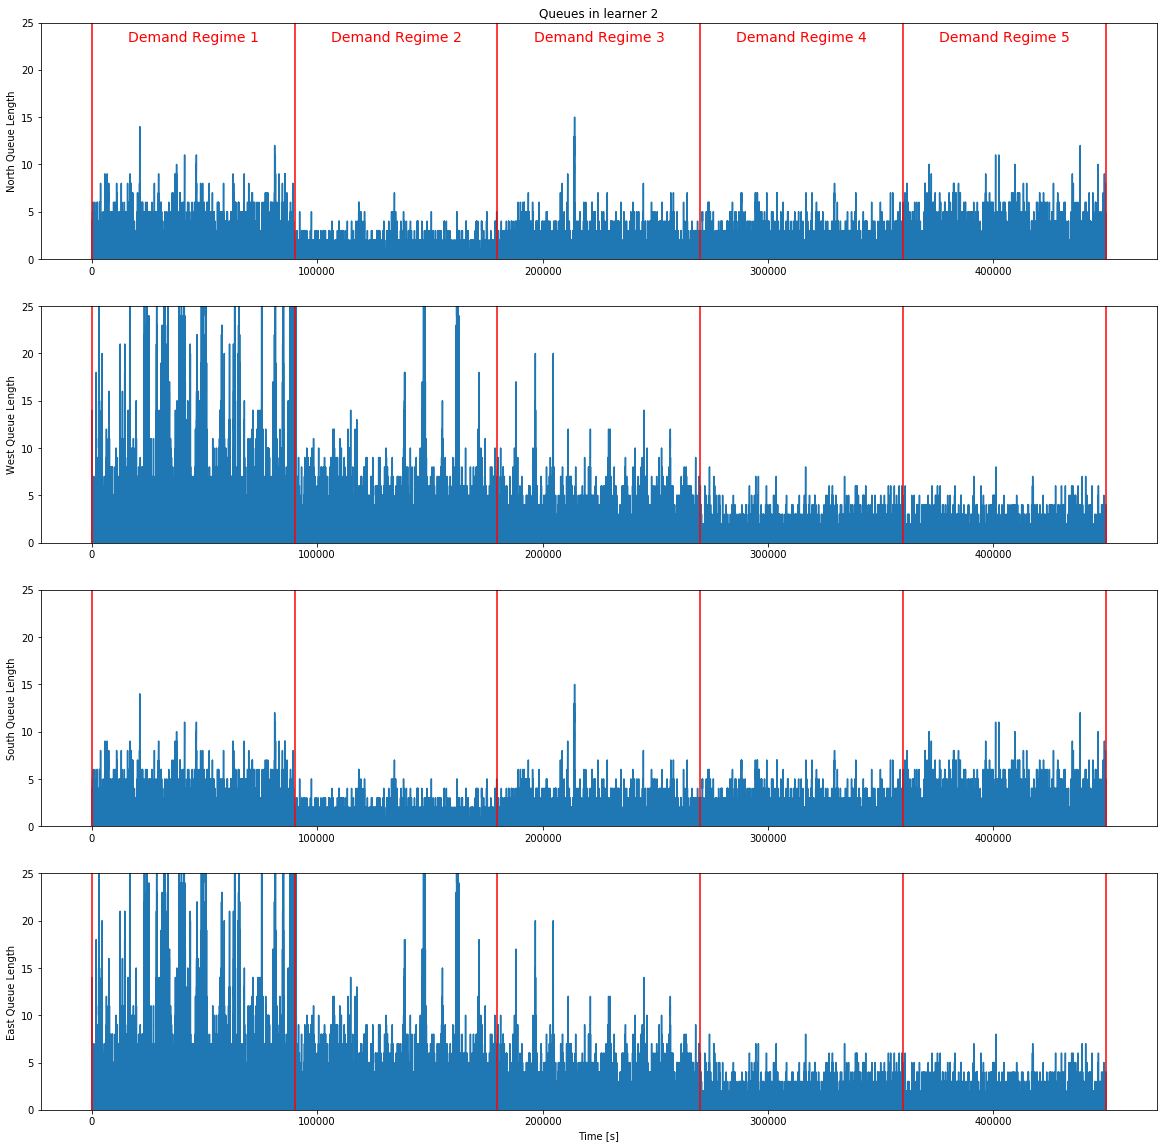

In [108]:
## PLOT FOR QUEUES
chosen_learner = 2
plt.figure(figsize=(20,20))
y1 = learners[chosen_learner].historic_queues[0][0:450000]
y2 = learners[chosen_learner].historic_queues[1][0:450000]
y3 = learners[chosen_learner].historic_queues[2][0:450000]
y4 = learners[chosen_learner].historic_queues[3][0:450000]

x1 = range(len(y1))
x2 = range(len(y1))
x3 = range(len(y1))
x4 = range(len(y1))

plt.subplot(4, 1, 1)
plt.plot(x1, y1, '-')
plt.ylim(0,25)
plt.title('Queues in learner '+str(chosen_learner))
plt.ylabel('North Queue Length')
xcoords = [0,90000,180000,270000,360000,450000]
for xc in xcoords:
    plt.axvline(x=xc, color='red')
    
texts = ['Demand Regime 1', 'Demand Regime 2', 'Demand Regime 3', 'Demand Regime 4', 'Demand Regime 5' ]
for i in range(len(texts)):
    plt.text(xcoords[i]+16000,23,texts[i], fontsize = 14, color='red')
    

plt.subplot(4, 1, 2)
plt.plot(x2, y2, '-')
plt.ylim(0,25)
plt.ylabel('West Queue Length')
xcoords = [0,90000,180000,270000,360000,450000]
for xc in xcoords:
    plt.axvline(x=xc, color='red')

plt.subplot(4, 1, 3)
plt.plot(x1, y1, '-')
plt.ylim(0,25)
plt.ylabel('South Queue Length')
xcoords = [0,90000,180000,270000,360000,450000]
for xc in xcoords:
    plt.axvline(x=xc, color='red')

plt.subplot(4, 1, 4)
plt.plot(x2, y2, '-')
plt.ylim(0,25)
plt.xlabel('Time [s]')
plt.ylabel('East Queue Length')
xcoords = [0,90000,180000,270000,360000,450000]
for xc in xcoords:
    plt.axvline(x=xc, color='red')

savedir = 'C:\\Users\\acabrejasegea\\OneDrive - The Alan Turing Institute\\Desktop\\ATI\\07_End_of_Internship_Presentation\\'
filename = 'queues_'+used_map+'_trained_learner_'+str(chosen_learner)+'.png'
plt.savefig(savedir+filename)

plt.show()

In [75]:
## Exporting Positional data as JSON
with open(used_map+'_timesteps_'+str(tracking_length)+'.json', 'w') as outfile:
    json.dump(positional_data, outfile)

SyntaxError: invalid syntax (<ipython-input-75-f4eed9c3e1ff>, line 2)

In [50]:
a = json.loads(output)
a

[[],
 [['left_1', [393.4, 1.6500000000000001]],
  ['right_0', [-194.9, -1.6500000000000001]]],
 [['left_1', [392.95640348624437, 1.6500000000000001]],
  ['right_0', [-194.38499734560028, -1.6500000000000001]]],
 [['left_1', [391.73099874099717, 1.6500000000000001]],
  ['right_0', [-193.26657277168707, -1.6500000000000001]]],
 [['down_2', [201.65, -194.9]],
  ['left_1', [389.9415759141557, 1.6500000000000001]],
  ['right_0', [-191.3655929314904, -1.6500000000000001]]],
 [['down_2', [201.65, -194.31811009170488]],
  ['left_1', [387.64945603935047, 1.6500000000000001]],
  ['right_0', [-188.7636132969521, -1.6500000000000001]]],
 [['down_2', [201.65, -193.20542174419387]],
  ['left_1', [384.8553839465603, 1.6500000000000001]],
  ['left_3', [393.4, 1.6500000000000001]],
  ['right_0', [-185.3640476981178, -1.6500000000000001]]],
 [['down_2', [201.65, -191.3985395979136]],
  ['left_1', [381.4477778097615, 1.6500000000000001]],
  ['left_3', [392.78084464604035, 1.6500000000000001]],
  ['right_